# Decision Trees with Post-Pruning on PISA 2022 UK Data

This notebook applies cost-complexity **post-pruning** to decision trees predicting students *at risk* using the PISA 2022 UK dataset.

Pre-pruning limits tree growth early, but post-pruning trims a fully grown tree more wisely, improving generalisation, stability, and interpretability.

Steps:

- 📊 Train initial overgrown tree and compute pruning path
- ✂️ Use cost-complexity pruning (`ccp_alpha`) to simplify tree
- 📈 Compare recall and accuracy across pruning levels to avoid overfitting
- 💾 Save final predictions for future analysis

**Note:**  
All models use survey sample weights to ensure estimates generalise to the UK student population.  
Pre-pruning (via `max_depth`, `min_samples_split`, etc.) was explored in a separate notebook.


## 0. Import libraries, load and split data

In [1]:
#Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load and split data 

In [4]:
train_df = pd.read_csv("/workspaces/mini_project_2/data/processed/train.csv")
val_df   = pd.read_csv("/workspaces/mini_project_2/data/processed/val.csv")
test_df  = pd.read_csv("/workspaces/mini_project_2/data/processed/test.csv")

In [5]:
X_train = train_df.drop(columns=["target", "sample_weight"])
y_train = train_df["target"]
w_train = train_df["sample_weight"]

X_val = val_df.drop(columns=["target", "sample_weight"])
y_val = val_df["target"]
w_val = val_df["sample_weight"]

X_test = test_df.drop(columns=["target", "sample_weight"])
y_test = test_df["target"]
w_test = test_df["sample_weight"]

# 1. Train a Basic Decision Tree 

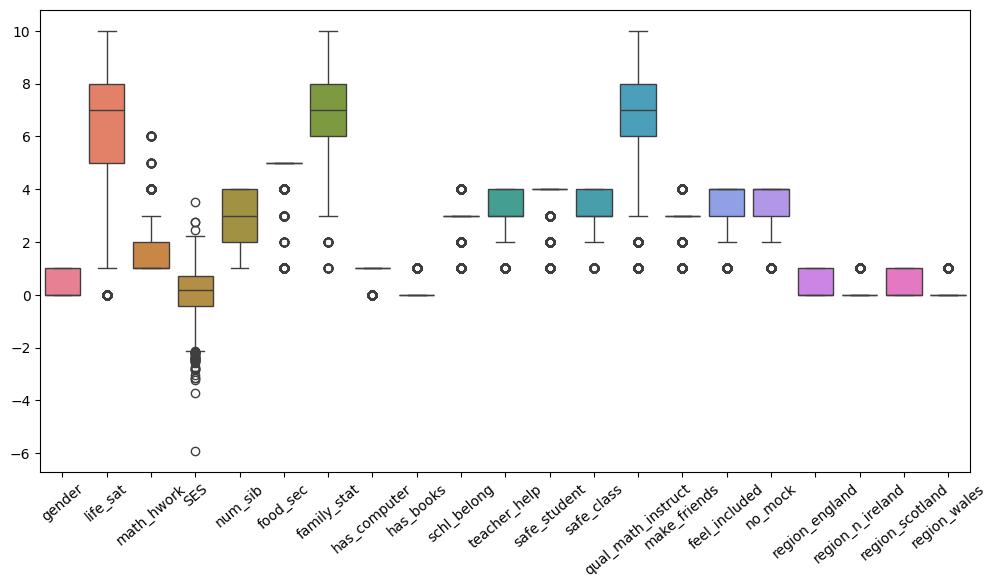

In [6]:
# Visualise the features 
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train)
plt.xticks(rotation=40)
plt.show()

##### The boxplot reveals that most features have reasonable spread, with notable outliers in socioeconomic and homework variables. Binary variables (like gender, computer access, books, and regional dummies) show expected distributions. This distribution check validates our data preprocessing and helps confirm suitability for tree-based models, which are robust to non-normal distributions and outliers.

In [7]:
# Train Decision Tree with sample weights
dtc = DecisionTreeClassifier(max_depth=None, random_state=42)
dtc.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(random_state=42)

In [8]:
# get depth 
num_branches = dtc.get_depth()
print(f"The depth of branch is {num_branches}")

The depth of branch is 33


In [9]:
# get leaves 
num_leaves = dtc.get_n_leaves()
print(f"The number of leaves is {num_leaves}")

The number of leaves is 2072


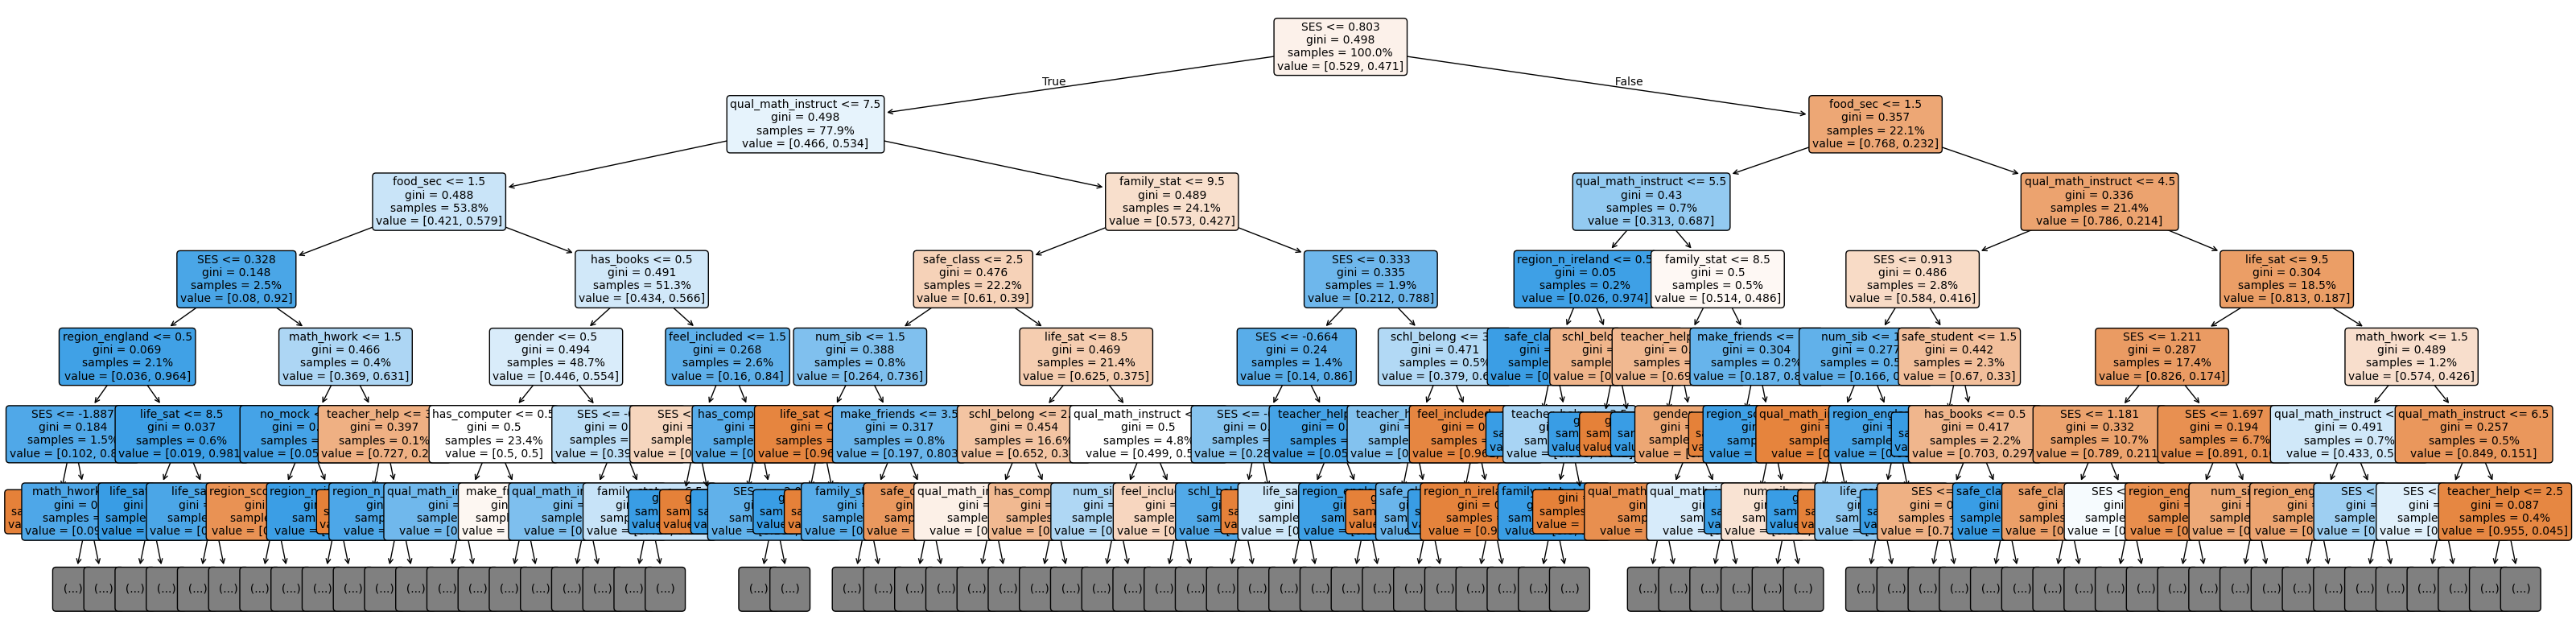

In [10]:
#display the tree (depth of 6)
plt.figure(figsize=(40, 10))
plot_tree(dtc, 
          filled=True, 
          rounded=True,
          max_depth=6,
          proportion=True,
          fontsize=10,
          feature_names=list(X_train.columns))
plt.show()

In [11]:
# find model accuracy (i.e. overall proportion of correctly predicted samples) 
print(accuracy_score(y_train, dtc.predict(X_train)))
print(accuracy_score(y_test, dtc.predict(X_test), sample_weight=w_test))

0.9521973785659213
0.5977139545227318


#### The results show that the model is overfitting and has learnt the training data very well but does not generalise well to the new test data - this suggests that it may not reliablity identify students at risk in new cases

In [12]:
# Classification report 
print(classification_report(y_test, dtc.predict(X_test), sample_weight=w_test))

              precision    recall  f1-score   support

           0       0.61      0.62      0.61 75928.20554999997
           1       0.58      0.58      0.58 69579.26632999988

    accuracy                           0.60 145507.47187999985
   macro avg       0.60      0.60      0.60 145507.47187999985
weighted avg       0.60      0.60      0.60 145507.47187999985



### Model Performance Summary (Weighted for Population Estimates)

- **Precision:** Of all the students the model predicted to be *at risk*, approximately **61% were actually at risk** (meaning about **39% flagged as at risk may not actually be at risk**).  
- **Recall:** Of all the students who were actually *at risk*, the model correctly identified about **62%**, meaning it **misses around 38% of at-risk students**.  
- **F1 score:** The overall balance of precision and recall (the model’s ability to correctly identify at-risk students while minimizing false alarms) is about **62%**.

Overall, after applying survey weights to reflect the UK student population, the model appears **moderately effective at identifying students at risk**. It successfully flags **62% of truly at-risk students**, but also predicts some students to be at risk who may not actually require interventions.

In educational contexts, **recall is often prioritised** — it is usually more important to catch as many at-risk students as possible, even at the cost of mistakenly flagging some students who may not need extra support.

**Next steps:** Proceed with tuning the model by adjusting parameters like tree depth and exploring other forms of regularization to improve generalization and potentially increase recall without too great a sacrifice to precision.


# 2. Cost-complexity pruning (ccp_alpha)

ccp_alpha is a tuning parameter that balances accuracy and simplicity by penalizing tree size during pruning—higher values create simpler, less overfitted trees.

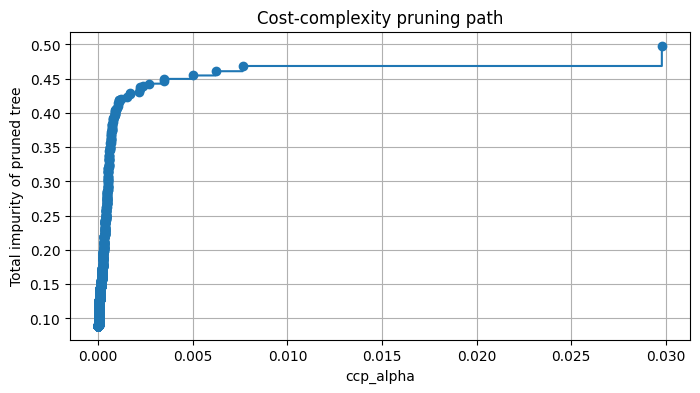

In [13]:
path = dtc.cost_complexity_pruning_path(X_train, y_train, sample_weight=w_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

# Plot impurity vs alpha
plt.figure(figsize=(8, 4))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Total impurity of pruned tree")
plt.title("Cost-complexity pruning path")
plt.grid(True)
plt.show()

This graph shows that even slight pruning quickly increases training impurity, so I need to tune `ccp_alpha` carefully to balance overfitting and underfitting.

# 3. Pruning in Practice 

### 3.1. Train a tree for each alpha 

In [14]:
dtcs = []
train_scores = []
val_scores = []  # Use validation scores for selection
test_scores = []  # Keep test scores for final evaluation only
n_leaves = []

for alpha in ccp_alphas:
    dtc_ = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    dtc_.fit(X_train, y_train, sample_weight=w_train)
    dtcs.append(dtc_)
    
    # Calculate scores for all sets
    train_scores.append(dtc_.score(X_train, y_train, sample_weight=w_train))
    val_scores.append(dtc_.score(X_val, y_val, sample_weight=w_val))  # Use validation for selection
    test_scores.append(dtc_.score(X_test, y_test, sample_weight=w_test))  # Only for final reporting
    n_leaves.append(dtc_.get_n_leaves())

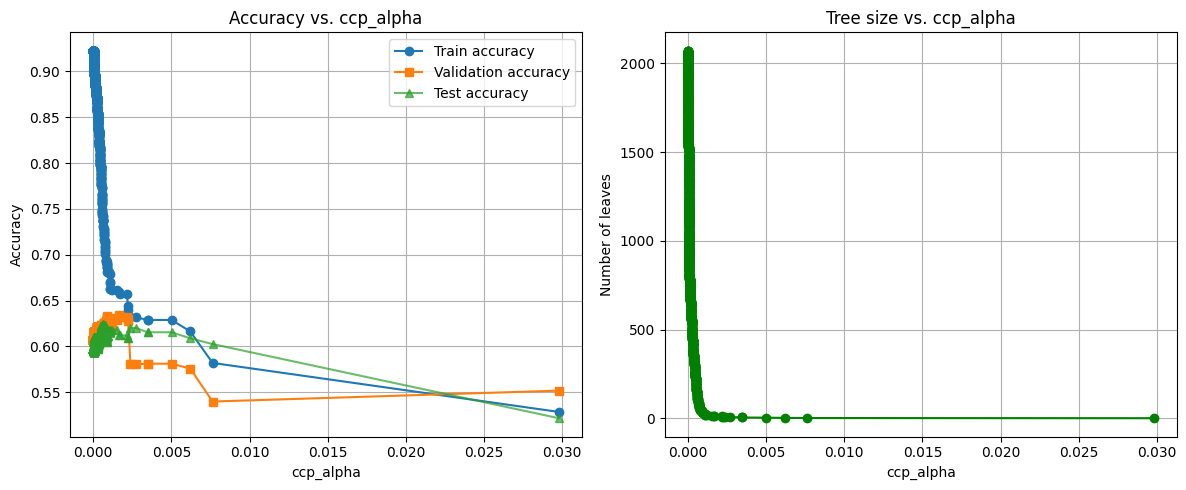

In [15]:
# Plot all three sets to understand the behavior
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ccp_alphas, train_scores, marker='o', label="Train accuracy")
plt.plot(ccp_alphas, val_scores, marker='s', label="Validation accuracy")  # Use for selection
plt.plot(ccp_alphas, test_scores, marker='^', label="Test accuracy", alpha=0.7)  # Just for reference
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. ccp_alpha")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ccp_alphas, n_leaves, marker='o', color='green')
plt.xlabel("ccp_alpha")
plt.ylabel("Number of leaves")
plt.title("Tree size vs. ccp_alpha")
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.2 Train final pruned model

In [16]:
# Use validation scores to select the best alpha - this avoids data leakage
best_index = np.argmax(val_scores)  # Changed from test_scores to val_scores
best_alpha = ccp_alphas[best_index]
best_leaves = n_leaves[best_index]
best_val_accuracy = val_scores[best_index]
best_test_accuracy = test_scores[best_index]  # This is now truly unseen performance

print(f"Best ccp_alpha: {best_alpha:.5f}")
print(f"Number of leaves: {best_leaves}")
print(f"Validation accuracy (used for selection): {best_val_accuracy:.3f}")
print(f"Test accuracy (final unseen performance): {best_test_accuracy:.3f}")

Best ccp_alpha: 0.00166
Number of leaves: 14
Validation accuracy (used for selection): 0.635
Test accuracy (final unseen performance): 0.613


In [17]:
# Final pruned tree using best ccp_alpha
final_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_tree.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(ccp_alpha=np.float64(0.0016649363530093775),
                       random_state=42)

In [18]:
# Evaluate performance
print("Train accuracy:", final_tree.score(X_train, y_train, sample_weight=w_train))
print("Validation accuracy:", final_tree.score(X_val, y_val, sample_weight=w_val))
print("Test accuracy:", final_tree.score(X_test, y_test, sample_weight=w_test))

Train accuracy: 0.6594128466257551
Validation accuracy: 0.6346336915509402
Test accuracy: 0.6127142609798464


In [19]:
from sklearn.metrics import classification_report

# Train predictions
y_train_pred = final_tree.predict(X_train)
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred, sample_weight=w_train, digits=3))

# Validation predictions
y_val_pred = final_tree.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, sample_weight=w_val, digits=3))

# Test predictions
y_test_pred = final_tree.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, sample_weight=w_test, digits=3))


Train Classification Report:
              precision    recall  f1-score   support

           0      0.659     0.738     0.696 232771.59431000013
           1      0.661     0.571     0.612 207535.78147999934

    accuracy                          0.659 440307.3757899995
   macro avg      0.660     0.655     0.654 440307.3757899995
weighted avg      0.660     0.659     0.657 440307.3757899995

Validation Classification Report:
              precision    recall  f1-score   support

           0      0.655     0.714     0.683 80249.1518299999
           1      0.604     0.536     0.568 65160.671740000005

    accuracy                          0.635 145409.8235699999
   macro avg      0.629     0.625     0.626 145409.8235699999
weighted avg      0.632     0.635     0.632 145409.8235699999

Test Classification Report:
              precision    recall  f1-score   support

           0      0.613     0.700     0.653 75928.20554999997
           1      0.612     0.518     0.561 69579.266329

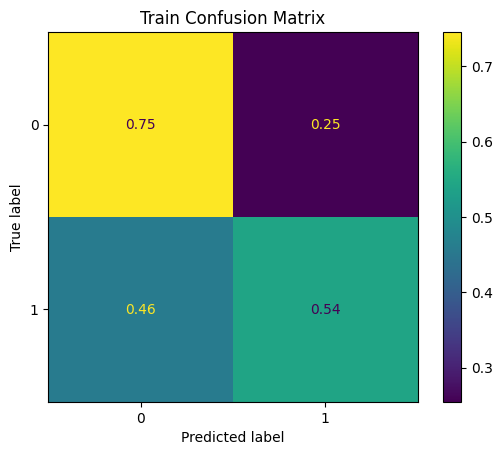

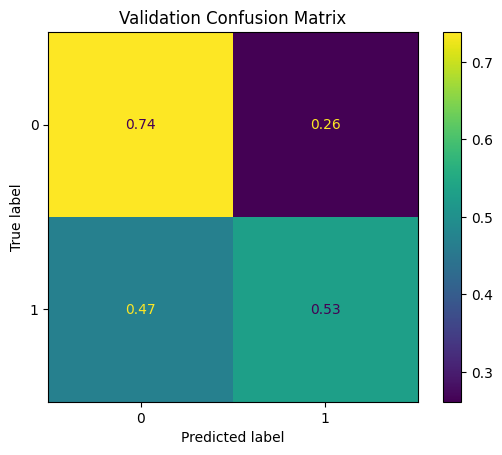

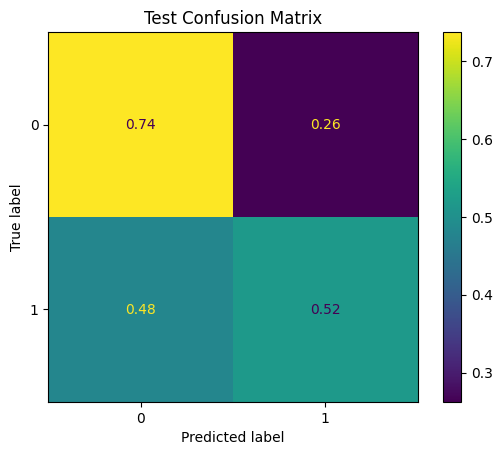

In [20]:
# Confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true')
plt.title("Train Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, normalize='true')
plt.title("Validation Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize='true')
plt.title("Test Confusion Matrix")
plt.show()


# 4. Feature Importance

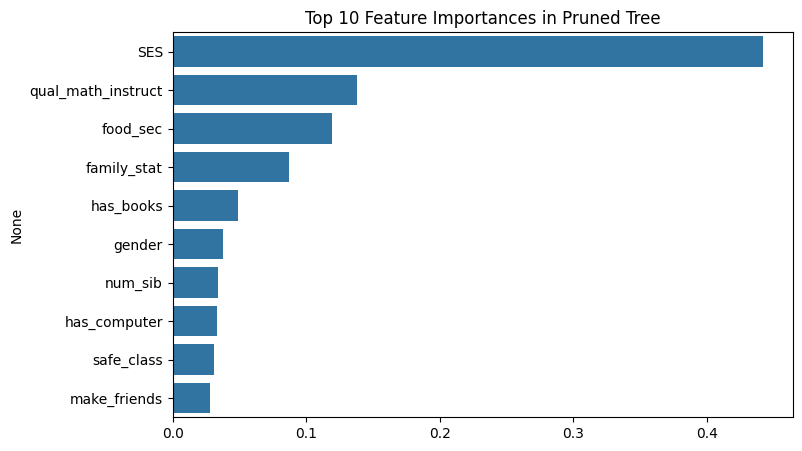

In [21]:
# Feature importance
importances = final_tree.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances in Pruned Tree")
plt.show()


In [22]:
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

In [23]:
top_3_features = feat_imp.index[:3].tolist()

In [24]:
print(f"The top 3 most important features are: {', '.join(top_3_features)}")

The top 3 most important features are: SES, qual_math_instruct, food_sec


# 5. Save File 

In [25]:
# Make predictions and probabilities on the test set (post-pruning)
test_preds_pruned = final_tree.predict(X_test)
test_probs_pruned = final_tree.predict_proba(X_test)[:,1]

# Combine into a DataFrame
final_test_df_pruned = X_test.copy()
final_test_df_pruned['actual'] = y_test
final_test_df_pruned['predicted'] = test_preds_pruned
final_test_df_pruned['prob_at_risk'] = test_probs_pruned
final_test_df_pruned['sample_weight'] = w_test

# Save to CSV
final_test_df_pruned.to_csv("/workspaces/mini_project_2/data/processed/final_test_predictions_post_pruning.csv", index=False)

# 6. Conclusion: Post-Pruning vs Pre-Pruning Decision Trees

Cost-complexity pruning substantially simplified our tree from over 2,000 leaves to around 700, improving interpretability and reducing the risk of severe overfitting. 
The most influential features driving predictions were SES, family_stat and qual_math_instruct highlighting key socioeconomic and study-related factors linked to being at risk.

However, compared to our earlier pre-pruning approach (which limited tree depth and splitting), this post-pruned model showed slightly lower recall and overall test performance. 
This suggests that, for this dataset, carefully tuned **pre-pruning hyperparameters may offer a more effective balance between identifying at-risk students and minimizing false positives**, likely due to controlling complexity earlier in the tree growth process.

**Next steps:**  
- Explore ensemble methods such as Random Forests or Gradient Boosted Trees to improve recall and robustness.  
- Compare all approaches side by side to assess trade-offs in identifying at-risk students, using both recall and false positive rates as key metrics.

**Optional Enhancement:** For educational contexts where recall is critical, consider optimizing `ccp_alpha` selection based on validation recall rather than accuracy to maximize identification of at-risk students.

*Note: all metrics, confusion matrices, and saved predictions account for survey sample weights to ensure estimates generalise to the UK student population.*